# Feature Engineering
## Sentiment Analysis, Lexical Features, LDA Topic Modeling
### Preparing a Model-Ready Dataset

In [1]:
# import/install libraries/packages
!pip install gensim
!pip install textblob
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
import pyLDAvis
from langdetect import detect

# allows inline display in Jupyter
pyLDAvis.enable_notebook()

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# initialize a sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /home/jupyter-
[nltk_data]     cradduhj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter-
[nltk_data]     cradduhj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read in final dataset file as CSV
df = pd.read_csv("final_dataset.csv")
df.head()

,title,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,pop,rock,hip-hop,r&b,country,jazz,electronic,reggae,metal,folk
0,...baby one more time,britney spears,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,...,1,0,0,0,0,0,1,1,0,0
1,doo wop (that thing),lauryn hill,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,...,0,0,1,1,0,0,0,1,0,0
2,have you ever?,brandy,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,...,1,0,0,1,0,0,0,0,0,0
3,love like this,faith evans,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,...,0,0,1,1,0,0,0,0,0,0
4,this kiss,faith hill,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,...,0,0,0,0,1,0,0,0,0,0


In [3]:
print(df.columns)
print(df.isna().sum())
print(df.dtypes)
print(df.describe())

Index(['title', 'artist', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'view_count', 'like_count', 'comment_count', 'chart_year',
       'lyrics', 'type_Group', 'type_Person', 'country_CA', 'country_GB',
       'country_Other', 'country_US', 'key_0', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'duration_min', 'begin_year', 'pop', 'rock', 'hip-hop', 'r&b',
       'country', 'jazz', 'electronic', 'reggae', 'metal', 'folk'],
      dtype='object')
title               0
artist              0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
view_count          0
like_count          0
comment_count       0
chart_year          0
lyrics              2
type_Group          0
type_Person      

In [4]:
# account for missing lyrics
df = df[df['lyrics'].notna()].reset_index(drop=True)

# conduct sentiment analysis on lyrics
pos_lyrics = []
neg_lyrics = []
neu_lyrics = []
compound_lyrics = []

# get sentiment scores from lyrics
for text in df['lyrics']:
    # analyze the sentiment
    scores_lyrics = sia.polarity_scores(text)

    # pull out scores
    pos_lyrics.append(scores_lyrics['pos'])
    neg_lyrics.append(scores_lyrics['neg'])
    neu_lyrics.append(scores_lyrics['neu'])
    compound_lyrics.append(scores_lyrics['compound'])

# add columns for scores
df['lyrics_pos'] = pos_lyrics
df['lyrics_neg'] = neg_lyrics
df['lyrics_neu'] = neu_lyrics
df['lyrics_compound'] = compound_lyrics

df.head()

,title,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,country,jazz,electronic,reggae,metal,folk,lyrics_pos,lyrics_neg,lyrics_neu,lyrics_compound
0,...baby one more time,britney spears,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,...,0,0,1,1,0,0,0.068,0.054,0.879,0.3382
1,doo wop (that thing),lauryn hill,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,...,0,0,0,1,0,0,0.141,0.054,0.805,0.9967
2,have you ever?,brandy,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,...,0,0,0,0,0,0,0.105,0.110,0.785,-0.4454
3,love like this,faith evans,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,...,0,0,0,0,0,0,0.374,0.021,0.605,0.9996
4,this kiss,faith hill,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,...,1,0,0,0,0,0,0.450,0.039,0.511,0.9997


In [5]:
# conduct sentiment analysis on titles
pos_titles = []
neg_titles = []
neu_titles = []
compound_titles = []

# get sentiment scores from titles
for text in df['title']:
    # analyze the sentiment
    scores_titles = sia.polarity_scores(text)

    # pull out scores
    pos_titles.append(scores_titles['pos'])
    neg_titles.append(scores_titles['neg'])
    neu_titles.append(scores_titles['neu'])
    compound_titles.append(scores_titles['compound'])

# add columns for scores
df['title_pos'] = pos_titles
df['title_neg'] = neg_titles
df['title_neu'] = neu_titles
df['title_compound'] = compound_titles

df.head()

,title,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,metal,folk,lyrics_pos,lyrics_neg,lyrics_neu,lyrics_compound,title_pos,title_neg,title_neu,title_compound
0,...baby one more time,britney spears,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,...,0,0,0.068,0.054,0.879,0.3382,0.000,0.0,1.000,0.0000
1,doo wop (that thing),lauryn hill,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,...,0,0,0.141,0.054,0.805,0.9967,0.000,0.0,1.000,0.0000
2,have you ever?,brandy,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,...,0,0,0.105,0.110,0.785,-0.4454,0.000,0.0,1.000,0.0000
3,love like this,faith evans,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,...,0,0,0.374,0.021,0.605,0.9996,0.870,0.0,0.130,0.7717
4,this kiss,faith hill,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,...,0,0,0.450,0.039,0.511,0.9997,0.737,0.0,0.263,0.4215


In [6]:
# get sentiment subjectivity
df['lyrics_subjectivity'] = df['lyrics'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

df.head()

,title,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,folk,lyrics_pos,lyrics_neg,lyrics_neu,lyrics_compound,title_pos,title_neg,title_neu,title_compound,lyrics_subjectivity
0,...baby one more time,britney spears,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,...,0,0.068,0.054,0.879,0.3382,0.000,0.0,1.000,0.0000,0.629464
1,doo wop (that thing),lauryn hill,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,...,0,0.141,0.054,0.805,0.9967,0.000,0.0,1.000,0.0000,0.539551
2,have you ever?,brandy,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,...,0,0.105,0.110,0.785,-0.4454,0.000,0.0,1.000,0.0000,0.561958
3,love like this,faith evans,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,...,0,0.374,0.021,0.605,0.9996,0.870,0.0,0.130,0.7717,0.622504
4,this kiss,faith hill,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,...,0,0.450,0.039,0.511,0.9997,0.737,0.0,0.263,0.4215,0.578056


In [7]:
# function to detect language
def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# apply to lyrics
df['language'] = df['lyrics'].apply(detect_lang)

# filter Spanish songs
spanish_songs = df[df['language'] == 'es']

In [8]:
# show all rows for visual analysis
pd.set_option('display.max_rows', None)

# remove english songs that slipped through
indexes_to_remove = [1331]

spanish_songs = spanish_songs.drop(index=indexes_to_remove)
# spanish_songs[['title','artist','lyrics']]

# remove spanish songs from df
df = df[df['language'] != 'es'].reset_index(drop=True)
df.shape

(5395, 56)

In [9]:
# remove standard stopwords but keep pronouns
stop_words = set(stopwords.words("english"))

# add custom domain-specific stopwords
custom_stopwords = {
    # common lyric fillers
    "yeah", "oh", "ooh", "ah", "uh", "ayy", "hey", "la", "woah", "huh", "woo",
    
    # mis-tokenized contractions / fragments
    "t", "s", "ll", "m", "re", "ve", "d", "em", "ya", "ma", "y",
    
    # slang, profanity, filler
    "gon", "gonna", "wanna", "gotta", "bout", "da",
    
    # extremely common verbs/do/aux words (lyric noise)
    "got", "get", "don", "ain", "let", "go", "make", "know",
    "be", "can", "do", "is", "see", "say", "give", "take", "come",
    "want", "wanna", "gonna", "need", "keep", "put",
    
    # generic pronouns (often useless for topic modeling)
    "i", "you", "me", "my", "your", "we", "they", "she", "he",
    "her", "him", "them", "us",
    
    # adverbs / connectors that slipped past stopwords
    "cause", "cuz", "yeah", "so", "just", "now", "out", "up", "down",
    "when", "if", "then", "too", "why", "here", "there", "where",
    "how", "as", "or", "and", "but",
    
    # short meaningless phonetic tokens
    "na", "ya", "ah", "uh",

    "ta", "ca", "like"
}

# combine both
stop_words = stop_words.union(custom_stopwords)

corpus_cleaned = []

# clean lyrics through tokenization
for text in df['lyrics']:
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    corpus_cleaned.append(" ".join(tokens))

/opt/tljh/user/lib/python3.12/site-packages/matplotlib/cbook.py:733: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x, subok=True, copy=copy)


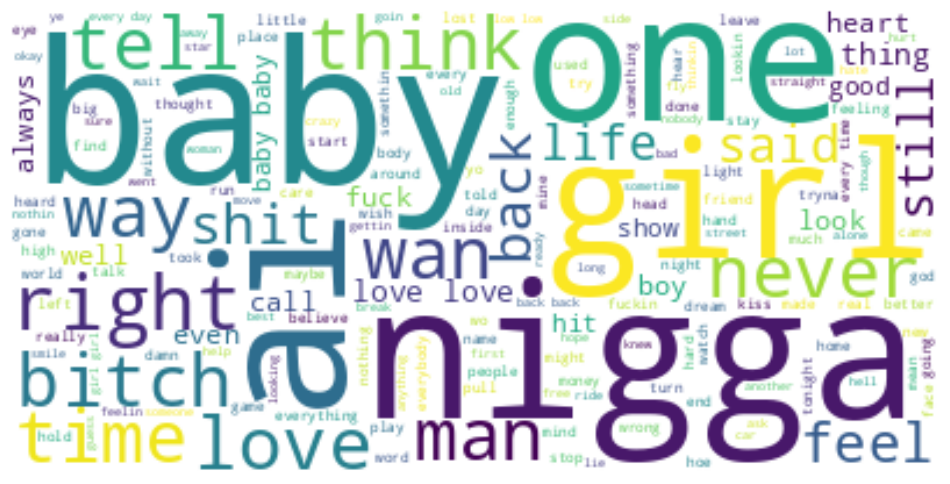

In [10]:
# join all the lyrics into one long string
long_lyrics = " ".join(corpus_cleaned)

# create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=1000,
    contour_width=3,
    contour_color='steelblue'
)

# generate the word cloud
wordcloud.generate(long_lyrics)

# visualize the word cloud using matplotlib
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # no axes
plt.show()

In [11]:
# get lexical features including word/char counts, avg. word length, unique words count, and vocab richness
df['word_count'] = df['lyrics'].str.split().apply(len)
df['char_count'] = df['lyrics'].str.len()
df['avg_word_len'] = df['char_count'] / df['word_count']
df['unique_words'] = df['lyrics'].apply(lambda x: len(set(x.split())))
df['vocab_richness'] = df['unique_words'] / df['word_count']
df.head()

,title,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,title_neg,title_neu,title_compound,lyrics_subjectivity,language,word_count,char_count,avg_word_len,unique_words,vocab_richness
0,...baby one more time,britney spears,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,...,0.0,1.000,0.0000,0.629464,en,319,1546,4.846395,98,0.307210
1,doo wop (that thing),lauryn hill,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,...,0.0,1.000,0.0000,0.539551,en,951,5066,5.327024,428,0.450053
2,have you ever?,brandy,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,...,0.0,1.000,0.0000,0.561958,en,485,2456,5.063918,141,0.290722
3,love like this,faith evans,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,...,0.0,0.130,0.7717,0.622504,en,439,2124,4.838269,132,0.300683
4,this kiss,faith hill,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,...,0.0,0.263,0.4215,0.578056,en,320,1720,5.375000,117,0.365625


In [12]:
# tokenized text
tokenized_lyrics = [text.split() for text in corpus_cleaned]

# dictionary and corpus
dictionary = corpora.Dictionary(tokenized_lyrics)
corpus_gensim = [dictionary.doc2bow(text) for text in tokenized_lyrics]

/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = 

K=5, Coherence=0.3736


/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = 

K=10, Coherence=0.3584


/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = 

K=20, Coherence=0.3528


/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = 

K=50, Coherence=0.3387


/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/tljh/user/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = 

K=100, Coherence=0.3352


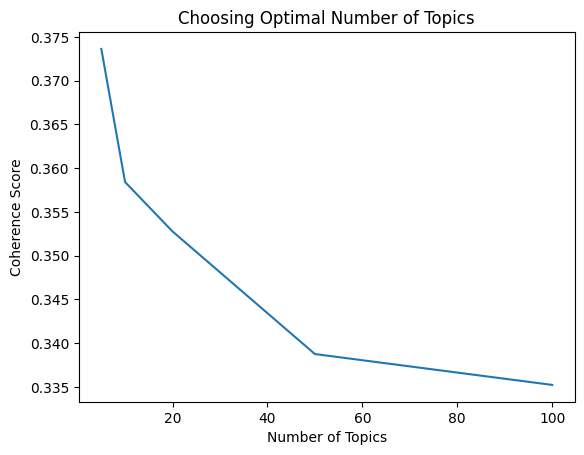

Topic Diversity: 0.6168


In [13]:
topic_nums = [5, 10, 20, 50, 100]
coherence_scores = []

for k in topic_nums:
    lda_k = LdaModel(
        corpus=corpus_gensim,
        id2word=dictionary,
        num_topics=k,
        passes=10,
        random_state=1234
    )
    
    coherence_model = CoherenceModel(
        model=lda_k,
        texts=tokenized_lyrics,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    print(f"K={k}, Coherence={coherence:.4f}")


plt.plot(topic_nums, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Choosing Optimal Number of Topics")
plt.show()

def topic_diversity(model, topk=25):
    topic_words = []
    for t in range(model.num_topics):
        words = [w for w, _ in model.show_topic(t, topk)]
        topic_words.extend(words)
    return len(set(topic_words)) / len(topic_words)

topic_div = topic_diversity(lda_k)
print("Topic Diversity:", topic_div)

In [14]:
# get final model
best_index = coherence_scores.index(max(coherence_scores))
best_k = topic_nums[best_index]
print(f"Best K by coherence: {best_k} (Coherence={coherence_scores[best_index]:.4f})")

lda_best = LdaModel(
    corpus=corpus_gensim,
    id2word=dictionary,
    num_topics=best_k,
    passes=10,
    random_state=1234
)

# lda_best is final model
LDAvis_prepared = pyLDAvis.gensim_models.prepare(
    lda_best,
    corpus_gensim,
    dictionary
)

# display the interactive visualization
LDAvis_prepared

Best K by coherence: 5 (Coherence=0.3736)


/opt/tljh/user/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/tljh/user/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/tljh/user/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/tljh/user/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=185610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/tljh/user/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.146818 -0.043743       1        1  33.893044
4      0.025764 -0.080425       2        1  27.496123
2     -0.010336 -0.119331       3        1  26.737802
3      0.064862  0.214273       4        1   7.126285
1     -0.227107  0.029225       5        1   4.746746, topic_info=                Term          Freq         Total Category  logprob  loglift
0               baby  10543.000000  10543.000000  Default  30.0000  30.0000
117             love  14308.000000  14308.000000  Default  29.0000  29.0000
678            nigga   7217.000000   7217.000000  Default  28.0000  28.0000
242              wan   7884.000000   7884.000000  Default  27.0000  27.0000
1264           bitch   5223.000000   5223.000000  Default  26.0000  26.0000
86              girl   7627.000000   7627.000000  Default  25.0000  25.0000
25              time   7294.000000   7294.000000  Default  24.0000  24.0000
78              feel   5256.000000   5256.000000  Default  23.0000  23.0000
880             shit   4393.000000   4393.000000  Default  22.0000  22.0000
1150            body   1682.000000   1682.000000  Default  21.0000  21.0000
1450            fuck   3577.000000   3577.000000  Default  20.0000  20.0000
1152           dance   1376.000000   1376.000000  Default  19.0000  19.0000
390          tonight   1860.000000   1860.000000  Default  18.0000  18.0000
17             right   5364.000000   5364.000000  Default  17.0000  17.0000
1227         alright   1169.000000   1169.000000  Default  16.0000  16.0000
177             stop   2145.000000   2145.000000  Default  15.0000  15.0000
128            money   2734.000000   2734.000000  Default  14.0000  14.0000
266             work   1378.000000   1378.000000  Default  13.0000  13.0000
114           little   2786.000000   2786.000000  Default  12.0000  12.0000
792             move   1388.000000   1388.000000  Default  11.0000  11.0000
509            party   1228.000000   1228.000000  Default  10.0000  10.0000
234            night   4165.000000   4165.000000  Default   9.0000   9.0000
311             turn   2079.000000   2079.000000  Default   8.0000   8.0000
133            never   6736.000000   6736.000000  Default   7.0000   7.0000
2032           shake    988.000000    988.000000  Default   6.0000   6.0000
156             rock   1082.000000   1082.000000  Default   5.0000   5.0000
363            light   1967.000000   1967.000000  Default   4.0000   4.0000
696            ready   1039.000000   1039.000000  Default   3.0000   3.0000
99             heart   3329.000000   3329.000000  Default   2.0000   2.0000
216             away   2760.000000   2760.000000  Default   1.0000   1.0000
1264           bitch   5221.673194   5223.119730   Topic1  -4.1015   1.0817
3097            gang    802.778564    803.543456   Topic1  -5.9740   1.0810
678            nigga   7210.151385   7217.887889   Topic1  -3.7789   1.0809
3253           skrrt    626.378859    627.156157   Topic1  -6.2222   1.0807
2136             lil   1207.743492   1209.260244   Topic1  -5.5656   1.0807
1464           pussy    775.344119    776.381669   Topic1  -6.0088   1.0806
4190            rack    481.690290    482.456155   Topic1  -6.4848   1.0804
1768            dick    487.383616    488.314459   Topic1  -6.4731   1.0801
631             bust    428.225655    429.089859   Topic1  -6.6025   1.0799
2542           wrist    420.685838    421.690114   Topic1  -6.6202   1.0796
1696             rap    300.918637    301.849784   Topic1  -6.9553   1.0789
1281           coupe    234.651962    235.436920   Topic1  -7.2040   1.0786
145           poppin    344.155437    345.354548   Topic1  -6.8210   1.0785
1725         drippin    199.567195    200.348466   Topic1  -7.3660   1.0781
855              hoe    836.534789    839.865266   Topic1  -5.9329   1.0780
4200           twerk    189.525689    190.294961   Topic1  -7.4176   1.0779
1901   

In [15]:
# perform LDA topic modeling
lda = LdaModel(
    corpus=corpus_gensim,
    id2word=dictionary,
    num_topics=7,
    passes=10,
    random_state=1234
)

# create interactive visualization
LDAvis_prepared = pyLDAvis.gensim_models.prepare(
    lda,
    corpus_gensim,
    dictionary
)

# display the interactive visualization
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.178631  0.062788       1        1  30.712578
4      0.052165  0.064714       2        1  21.191491
2      0.064048 -0.027604       3        1  20.726356
3      0.018627  0.196169       4        1   8.726165
1      0.153887 -0.039060       5        1   8.583173
6      0.088413 -0.136111       6        1   5.759407
5     -0.198510 -0.120895       7        1   4.300830, topic_info=                Term          Freq         Total Category  logprob  loglift
0               baby  10617.000000  10617.000000  Default  30.0000  30.0000
117             love  14170.000000  14170.000000  Default  29.0000  29.0000
678            nigga   7288.000000   7288.000000  Default  28.0000  28.0000
242              wan   7889.000000   7889.000000  Default  27.0000  27.0000
86              girl   7710.000000   7710.000000  Default  26.0000  26.0000
1264           bitch   5273.000000   5273.000000  Default  25.0000  25.0000
216             away   2623.000000   2623.000000  Default  24.0000  24.0000
78              feel   5176.000000   5176.000000  Default  23.0000  23.0000
25              time   7264.000000   7264.000000  Default  22.0000  22.0000
880             shit   4444.000000   4444.000000  Default  21.0000  21.0000
1450            fuck   3617.000000   3617.000000  Default  20.0000  20.0000
337              run   1926.000000   1926.000000  Default  19.0000  19.0000
1150            body   1714.000000   1714.000000  Default  18.0000  18.0000
99             heart   3273.000000   3273.000000  Default  17.0000  17.0000
234            night   4197.000000   4197.000000  Default  16.0000  16.0000
266             work   1406.000000   1406.000000  Default  15.0000  15.0000
296             ride   1300.000000   1300.000000  Default  14.0000  14.0000
1152           dance   1412.000000   1412.000000  Default  13.0000  13.0000
13               one   7884.000000   7884.000000  Default  12.0000  12.0000
133            never   6749.000000   6749.000000  Default  11.0000  11.0000
17             right   5378.000000   5378.000000  Default  10.0000  10.0000
128            money   2762.000000   2762.000000  Default   9.0000   9.0000
229             life   4113.000000   4113.000000  Default   8.0000   8.0000
390          tonight   1899.000000   1899.000000  Default   7.0000   7.0000
122            maybe   1318.000000   1318.000000  Default   6.0000   6.0000
27             would   2930.000000   2930.000000  Default   5.0000   5.0000
59             could   4611.000000   4611.000000  Default   4.0000   4.0000
26               way   6012.000000   6012.000000  Default   3.0000   3.0000
177             stop   2165.000000   2165.000000  Default   2.0000   2.0000
484             high   1420.000000   1420.000000  Default   1.0000   1.0000
3097            gang    810.297850    811.315382   Topic1  -5.8662   1.1792
631             bust    432.298739    433.248648   Topic1  -6.4945   1.1783
2136             lil   1216.822022   1220.886421   Topic1  -5.4596   1.1772
1264           bitch   5253.094468   5273.093906   Topic1  -3.9970   1.1767
4200           twerk    191.316640    192.140326   Topic1  -7.3097   1.1762
1464           pussy    780.146273    783.799053   Topic1  -5.9041   1.1758
7792            nope    171.987579    172.812046   Topic1  -7.4162   1.1757
1927          rapper    213.162155    214.214678   Topic1  -7.2015   1.1756
14107          cardi    158.685544    159.509144   Topic1  -7.4967   1.1753
1768            dick    490.391150    493.026020   Topic1  -6.3684   1.1751
3184            plug    151.442077    152.292364   Topic1  -7.5434   1.1749
6703            slim    140.789936    141.618854   Topic1  -7.6163   1.1746
4590           molly    154.074927    154.994913   Topic1  -7.5261   1.1745
4169            baow    145.634660    146.520230   Topic1  -7.5825   1.1744
4190            rack    483.946576    487.029385   

In [16]:
# print out topics
lda.print_topics()

[(0,
  '0.025*"nigga" + 0.018*"bitch" + 0.015*"shit" + 0.014*"ai" + 0.012*"fuck" + 0.009*"money" + 0.007*"back" + 0.005*"big" + 0.005*"hit" + 0.005*"as"'),
 (1,
  '0.039*"love" + 0.025*"time" + 0.021*"feel" + 0.014*"heart" + 0.012*"life" + 0.010*"wan" + 0.009*"alright" + 0.008*"tonight" + 0.008*"wo" + 0.007*"mind"'),
 (2,
  '0.014*"night" + 0.012*"one" + 0.011*"back" + 0.010*"way" + 0.010*"never" + 0.010*"day" + 0.009*"time" + 0.009*"home" + 0.008*"every" + 0.007*"world"'),
 (3,
  '0.087*"baby" + 0.043*"wan" + 0.016*"right" + 0.015*"girl" + 0.014*"body" + 0.013*"dance" + 0.013*"way" + 0.011*"stop" + 0.010*"move" + 0.009*"turn"'),
 (4,
  '0.046*"love" + 0.028*"girl" + 0.017*"ai" + 0.017*"never" + 0.015*"one" + 0.013*"baby" + 0.011*"could" + 0.011*"back" + 0.010*"tell" + 0.010*"wan"'),
 (5,
  '0.018*"feel" + 0.014*"work" + 0.014*"ride" + 0.009*"high" + 0.009*"look" + 0.008*"rock" + 0.007*"thank" + 0.007*"fire" + 0.007*"black" + 0.007*"gim"'),
 (6,
  '0.031*"away" + 0.016*"run" + 0.013*"o

In [17]:
song_topics = [lda.get_document_topics(bow, minimum_probability=0) for bow in corpus_gensim]
X_lda = np.array([[prob for _, prob in song] for song in song_topics])
# add to dataframe 
lda_df = pd.DataFrame(X_lda, columns=[f'Topic_{i+1}' for i in range(X_lda.shape[1])])

In [18]:
# rename topics
topic_names = {
    1: "Rap_Street_Slang_Topic",
    2: "Romance_Relationships_Topic",
    3: "Life_Nostalgia_Topic",
    4: "Party_Dance_Sensuality_Topic",
    5: "Love_Emotion_Sentiment_Topic",
    6: "Loss_Struggle_Reflection_Topic",
    7: "Energy_Vibes_Epic_Topic"
}

# rename columns
lda_df.rename(columns={f"Topic_{i}": topic_names[i] for i in topic_names}, inplace=True)

# add to dataframe
df = pd.concat([df, lda_df], axis=1)

In [19]:
print(df.columns)
print(df.shape)
df.head()

Index(['title', 'artist', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'view_count', 'like_count', 'comment_count', 'chart_year',
       'lyrics', 'type_Group', 'type_Person', 'country_CA', 'country_GB',
       'country_Other', 'country_US', 'key_0', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'duration_min', 'begin_year', 'pop', 'rock', 'hip-hop', 'r&b',
       'country', 'jazz', 'electronic', 'reggae', 'metal', 'folk',
       'lyrics_pos', 'lyrics_neg', 'lyrics_neu', 'lyrics_compound',
       'title_pos', 'title_neg', 'title_neu', 'title_compound',
       'lyrics_subjectivity', 'language', 'word_count', 'char_count',
       'avg_word_len', 'unique_words', 'vocab_richness',
       'Rap_Street_Slang_Topic', 'Romance_Relationships_Topic',
       'Life_Nostalgia_Topic', 'Party_Dance_Sensuality_Topic',
       'Love_Emotion_Sentime

,title,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,avg_word_len,unique_words,vocab_richness,Rap_Street_Slang_Topic,Romance_Relationships_Topic,Life_Nostalgia_Topic,Party_Dance_Sensuality_Topic,Love_Emotion_Sentiment_Topic,Loss_Struggle_Reflection_Topic,Energy_Vibes_Epic_Topic
0,...baby one more time,britney spears,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,...,4.846395,98,0.307210,0.001245,0.001247,0.001247,0.362314,0.385711,0.001244,0.246992
1,doo wop (that thing),lauryn hill,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,...,5.327024,428,0.450053,0.192193,0.030384,0.000396,0.015850,0.760386,0.000396,0.000396
2,have you ever?,brandy,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,...,5.063918,141,0.290722,0.000765,0.418962,0.230767,0.000766,0.347208,0.000765,0.000766
3,love like this,faith evans,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,...,4.838269,132,0.300683,0.000900,0.000902,0.000901,0.000906,0.994590,0.000900,0.000901
4,this kiss,faith hill,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,...,5.375000,117,0.365625,0.001012,0.324886,0.046997,0.624069,0.001012,0.001011,0.001014


In [20]:
# rename some of the columns (the key columns)
df = df.rename(columns = {
    "key_0": "key_C",
    "key_1": "key_C_Sharp",
    "key_2": "key_D",
    "key_3": "key_D_Sharp",
    "key_4": "key_E",
    "key_5": "key_F",
    "key_6": "key_F_Sharp",
    "key_7": "key_G",
    "key_8": "key_G_Sharp",
    "key_9": "key_A",
    "key_10": "key_A_Sharp",
    "key_11": "key_B"
})

In [26]:
# drop columns from the data set that we will no longer need in terms of prediction ("lyrics", title", "artist", "like_count", "comment_count")
df = df.drop(["lyrics", "title", "artist", "like_count",  "comment_count", "char_count", "language"], axis = 1)

In [27]:
print(df.columns)
print(df.isna().sum())
print(df.shape)
df.head()

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'view_count',
       'chart_year', 'type_Group', 'type_Person', 'country_CA', 'country_GB',
       'country_Other', 'country_US', 'key_C', 'key_C_Sharp', 'key_D',
       'key_D_Sharp', 'key_E', 'key_F', 'key_F_Sharp', 'key_G', 'key_G_Sharp',
       'key_A', 'key_A_Sharp', 'key_B', 'duration_min', 'begin_year', 'pop',
       'rock', 'hip-hop', 'r&b', 'country', 'jazz', 'electronic', 'reggae',
       'metal', 'folk', 'lyrics_pos', 'lyrics_neg', 'lyrics_neu',
       'lyrics_compound', 'title_pos', 'title_neg', 'title_neu',
       'title_compound', 'lyrics_subjectivity', 'word_count', 'avg_word_len',
       'unique_words', 'vocab_richness', 'Rap_Street_Slang_Topic',
       'Romance_Relationships_Topic', 'Life_Nostalgia_Topic',
       'Party_Dance_Sensuality_Topic', 'Love_Emotion_Sentiment_Topic',
       'Loss_Struggle_Reflection_Topic', 'Energy_Vibes_Epic_T

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,view_count,...,avg_word_len,unique_words,vocab_richness,Rap_Street_Slang_Topic,Romance_Relationships_Topic,Life_Nostalgia_Topic,Party_Dance_Sensuality_Topic,Love_Emotion_Sentiment_Topic,Loss_Struggle_Reflection_Topic,Energy_Vibes_Epic_Topic
0,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,0.907,1.118930e+09,...,4.846395,98,0.307210,0.001245,0.001247,0.001247,0.362314,0.385711,0.001244,0.246992
1,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,0.495,2.205607e+08,...,5.327024,428,0.450053,0.192193,0.030384,0.000396,0.015850,0.760386,0.000396,0.000396
2,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,0.275,8.756409e+07,...,5.063918,141,0.290722,0.000765,0.418962,0.230767,0.000766,0.347208,0.000765,0.000766
3,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,0.796,1.049947e+07,...,4.838269,132,0.300683,0.000900,0.000902,0.000901,0.000906,0.994590,0.000900,0.000901
4,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,0.709,2.109060e+07,...,5.375000,117,0.365625,0.001012,0.324886,0.046997,0.624069,0.001012,0.001011,0.001014


In [28]:
# save dataframe to CSV
df.to_csv("model_ready_dataset.csv", index=False)